Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900


<Axes: >

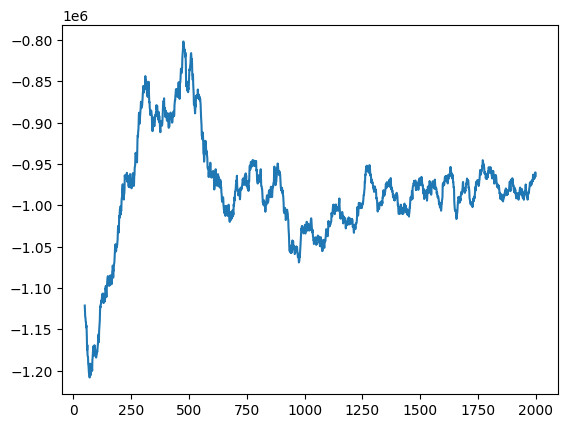

In [2]:
import os
import json
import random
from collections import deque
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import sys
# set python path
sys.path.append('/Users/vchester/Documents/school/MBAn/6.8200/6.8200-Unit-Commitment/src')

from rl4uc.environment import make_env_from_json
from rl4uc import processor

class QAgent(nn.Module):
    def __init__(self, env):
        super(QAgent, self).__init__()
        self.num_gen = env.num_gen
        
        self.num_nodes = 32
        self.gamma = 0.99
        self.activation = torch.tanh
        
        # There are 2N output nodes, corresponding to ON/OFF for each generator
        self.n_out = 2*self.num_gen
        
        self.forecast_horizon = 12
        self.obs_processor = processor.LimitedHorizonProcessor(env, forecast_horizon=self.forecast_horizon)
        self.obs_size = self.process_observation(env.reset()).size
        
        self.in_layer = nn.Linear(self.obs_size, self.num_nodes)
        self.out_layer = nn.Linear(self.num_nodes, self.n_out) 
        
        self.optimizer = optim.Adam(self.parameters(), lr=3e-04)
        self.criterion = nn.MSELoss()
        
                
    def process_observation(self, obs):
        """
        Process an observation into a numpy array.
        
        Observations are given as dictionaries, which is not very convenient
        for function approximation. Here we take just the generator up/down times
        and the timestep.
        
        Customise this!
        """
        obs_new = np.concatenate((obs['status'], [obs['timestep']]))
        # obs_new = self.obs_processor.process(obs)
        return obs_new
    
    def forward(self, obs):
        x = torch.as_tensor(obs).float()
        x = self.activation(self.in_layer(x))
        return self.out_layer(x)
        
    def act(self, obs):
        """
        Agent always acts greedily w.r.t Q-values!
        """
        processed_obs = self.process_observation(obs)

        q_values = self.forward(processed_obs)
        q_values = q_values.reshape(self.num_gen, 2)
        action = q_values.argmax(axis=1).detach().numpy()
        
        return action, processed_obs
    
    def update(self, memory, batch_size=None):
        
        if batch_size == None:
            batch_size = memory.capacity
        
        data = memory.sample(batch_size)
        
        qs = self.forward(data['obs']).reshape(batch_size, self.num_gen, 2)
        
        # A bit of complicated indexing here! 
        # We are using the actions [batch_size, num_gen] to index Q-values
        # which have shape [batch_size, num_gen, 2]
        m,n = data['act'].shape
        I,J = np.ogrid[:m,:n]
        qs = qs[I, J, data['act']]
        
        next_qs = self.forward(data['next_obs']).reshape(batch_size, self.num_gen, 2)
        next_acts = next_qs.argmax(axis=2).detach().numpy()
        
        # The same complicated indexing! 
        m,n = next_acts.shape
        I,J = np.ogrid[:m,:n]
        next_qs = next_qs[I, J, next_acts]
        
        # Recasting rewards into the same shape as next_qs
        m,n = next_qs.shape
        rews = np.broadcast_to(data['rew'], (self.num_gen,batch_size)).T
        rews = torch.as_tensor(rews).float()

        td_target = rews + self.gamma * next_qs
                
        criterion = nn.MSELoss()
        loss = criterion(qs, td_target)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

class ReplayMemory(object):

    def __init__(self, capacity, obs_size, act_dim):
        
        self.capacity = capacity
        self.obs_size = obs_size
        self.act_dim = act_dim 
        
        self.act_buf = np.zeros((self.capacity, self.act_dim))
        self.obs_buf = np.zeros((self.capacity, self.obs_size))
        self.rew_buf = np.zeros(self.capacity)
        self.next_obs_buf = np.zeros((self.capacity, self.obs_size))
        
        self.num_used = 0
        
    def store(self, obs, action, reward, next_obs):
        idx = self.num_used % self.capacity
        
        self.act_buf[idx] = action
        self.obs_buf[idx] = obs
        self.rew_buf[idx] = reward
        self.next_obs_buf[idx] = next_obs
        
        self.num_used += 1
    
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(self.capacity), size=batch_size, replace=False)
        
        data = {'act': self.act_buf[idx],
                'obs': self.obs_buf[idx],
                'rew': self.rew_buf[idx],
                'next_obs': self.next_obs_buf[idx]}
        
        return data
        
    def is_full(self):
        return (self.num_used >= self.capacity)
    
    def reset(self):
        self.num_used = 0 
        
def train():
    
    MEMORY_SIZE = 200
    N_EPOCHS = 2000
    
    env = make_env_from_json('10gen')
    agent = QAgent(env)
    memory = ReplayMemory(MEMORY_SIZE, agent.obs_size, env.num_gen)
    
    log = {'mean_timesteps': [],
           'mean_reward': []}
    
    for i in range(N_EPOCHS):
        if i % 100 == 0:
            print("Epoch {}".format(i))
        epoch_timesteps = []
        epoch_rewards = []
        while memory.is_full() == False:
            done = False
            obs = env.reset()
            timesteps = 0
            while not done: 
                action, processed_obs = agent.act(obs)
                next_obs, reward, done, _ = env.step(action)
                
                if not done:
                    next_obs_processed = agent.process_observation(next_obs)
                    memory.store(processed_obs, action, reward, next_obs_processed)
                
                obs = next_obs
                
                if memory.is_full():
                    break
                
                timesteps += 1
                if done:
                    epoch_rewards.append(reward)
                    epoch_timesteps.append(timesteps)
                    
        log['mean_timesteps'].append(np.mean(epoch_timesteps))
        log['mean_reward'].append(np.mean(epoch_rewards))
        
        agent.update(memory)
        memory.reset()
                    
    return agent, log

agent, log = train()
pd.Series(log['mean_reward']).rolling(50).mean().plot()